In [ ]:
# Using earthaccess access pattern for direct access "streaming" of cloud-hosted 
# MEaSUREs Phase-Based Antarctica Ice Velocity Map, Version 1
# 
# Code  written to run on CryoCloud cloud-computing JupyterHub
# Learn more: https://cryointhecloud.com/
# 
# Written 2023-11-15 by Wilson Sauthoff (wsauthoff.github.io)

In [1]:
# Import libraries
import earthaccess
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import xarray as xr

In [2]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 11/27/2023
Using .netrc file for EDL


In [3]:
# Find cloud-hosted MEaSUREs Phase-Based Antarctica Ice Velocity Map, Version 1
# DOI from https://nsidc.org/data/NSIDC-0754/versions/1
results = earthaccess.search_data(
    doi='10.5067/FPSU0V1MWUB6',
    cloud_hosted=True,
    bounding_box=(1, -89, -1, -89)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

Granules found: 1


In [4]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

 Opening 1 granules, approx size: 0.79 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0756.003/1970.01.01/BedMachineAntarctica-v3.nc>]

In [5]:
# Print file name to ensure expected dataset
print(files[0])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0756.003/1970.01.01/BedMachineAntarctica-v3.nc>


In [6]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
bedmachine = xr.open_dataset(files[0])
bedmachine

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 ...
    firn       (y, x) float32 ...
    surface    (y, x) float32 ...
    thickness  (y, x) float32 ...
    bed        (y, x) float32 ...
    errbed     (y, x) float32 ...
    source     (y, x) int8 ...
    dataid     (y, x) int8 ...
    geoid      (y, x) int16 ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [7]:
# Specify the variables to keep
variables_to_keep = ['x', 'y', 'surface', 'thickness', 'bed']

variables_to_drop = [var for var in bedmachine.variables if var not in variables_to_keep]

# Drop variables to reduce memory consumption
bedmachine = bedmachine.drop_vars(variables_to_drop)
bedmachine

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    surface    (y, x) float32 ...
    thickness  (y, x) float32 ...
    bed        (y, x) float32 ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [8]:
# Define bounding box of interest in polar stereographic coordinates
# (here Slessor Glacier, East Antarctica)
xmin=-600000
ymin=870000
xmax=-180000
ymax=1290000

# Subset BedMachine data within bounding box, assign to variable
bedmachine_sub = bedmachine.where((bedmachine.x > xmin) & (bedmachine.x < xmax) & (bedmachine.y > ymin) & (bedmachine.y < ymax), drop=True)

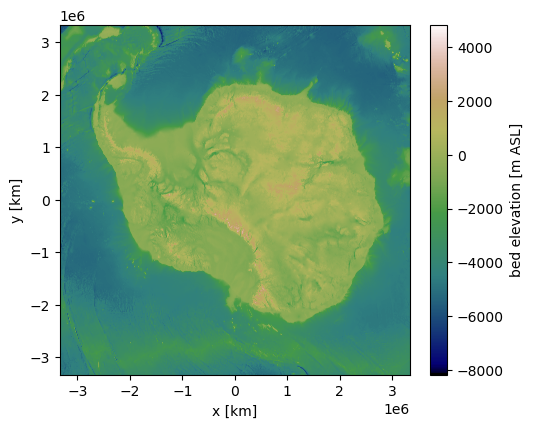

In [18]:
# Visualize bed elevation 
fig, ax = plt.subplots(figsize=(5,5))
m = ax.imshow(bedmachine['bed'],
    extent=[bedmachine.x.min(), bedmachine.x.max(), bedmachine.y.min(), bedmachine.y.max()],
    cmap='gist_earth')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
#TODO plotting along pixel values, but using axes limits plots nothing; remendy plotting issue
ax.set_xlim(bedmachine.x.min(), bedmachine.x.max())
ax.set_ylim(bedmachine.y.min(), bedmachine.y.max())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(mappable, cax=cax)
cbar.set_label('bed elevation [m ASL]')
plt.show()